# A simple neural network in Julia
Based on Andrew Ng's Machine Learning course in Coursera

## loading data

In [63]:
using MNIST # hand written digits

trainX, trainY = traindata();
testX, testY = testdata();

In [64]:
# limit the dataset for demonstration purpose
trainX = trainX[:,1:5000]
trainY = trainY[1:5000]

testX = testX[:,1:1000]
testY = testY[1:1000]

trainY = round(Int, trainY) + 1 # convert to integer and allow indexing later
testY = round(Int, testY) + 1 # convert to integer and allow indexing later

print("Number of features: ", size(trainX,1), " (28x28 grey scale image)")
print("\n")
print("Number of training examples: ", size(trainX,2))
print("\n")
print("Number of testing examples: ", size(testX,2))

Number of features: 784 (28x28 grey scale image)
Number of training examples: 5000
Number of testing examples: 1000

##visualization

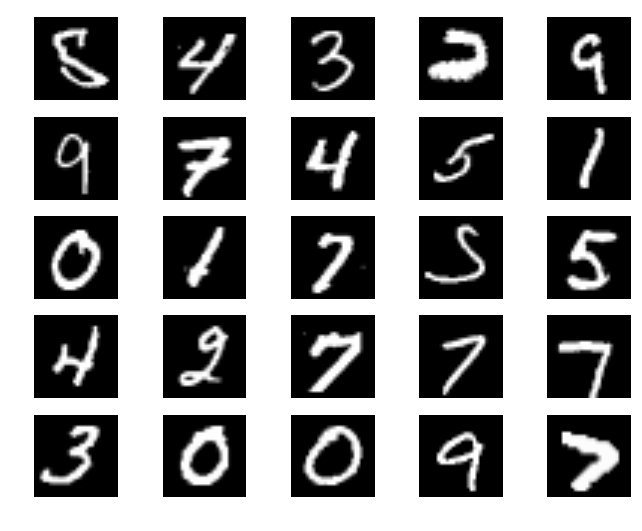

In [65]:
# display random images from the training set
using PyPlot;

for i = 1:25
    PyPlot.subplot(5,5,i)
    PyPlot.axis("off")
    PyPlot.imshow(reshape(trainX'[rand(1:size(trainX',1)),:],28,28), cmap=PyPlot.ColorMap("gray"))
end

##adding bias

In [ ]:
m = size(trainX,2) # number of training examples
X = trainX'
y = trainY'
a1 = [ones(m, 1) X] # adding bias units set to 1

mtest = size(testX,2) # number of testing examples
Xtest = testX'
ytest = testY'
a1test = [ones(mtest, 1) Xtest] # adding bias units set to 1

##model

In [ ]:
input_layer_size = size(X,2) #input layer
hidden_layer_size = 20 # hidden layer
num_labels = 10 # output layer, number of digits for classification, 0-9

lambda = 1 # regularization parameter
iterations = 10

In [68]:
# prepare target for multiclass classification
Y = zeros(m,num_labels)
for i = 1:m
    Y[i, y[i]] = 1
end

Ytest = zeros(mtest,num_labels)
for i = 1:mtest
    Ytest[i, ytest[i]] = 1
end

In [69]:
# randomly initialize weights between input and hidden layers (Theta1), 
# and between hidden and output layers (Theta2)
epsilon_init = 0.12;
Theta1 = rand(hidden_layer_size,input_layer_size+1) * 2 * epsilon_init - epsilon_init
Theta2 = rand(num_labels,hidden_layer_size+1) * 2 * epsilon_init - epsilon_init
Theta = vcat(Theta1[:], Theta2[:]) #unroll weights as required by optimization algorithm

15910-element Array{Float64,1}:
  0.015542 
 -0.0684075
 -0.0676625
 -0.0520667
 -0.0112599
 -0.0727172
  0.015462 
 -0.0774393
  0.0935164
  0.0219391
  0.0276756
 -0.0907612
 -0.027141 
  ⋮        
 -0.0341042
 -0.0160008
  0.0804715
 -0.030974 
  0.0161215
 -0.0513373
  0.112369 
 -0.0313275
  0.0438845
  0.0999667
  0.0276322
  0.101953 

In [70]:
zigmoid(z) =  1.0 ./ (1.0 + exp(-z)) # sigmoid function

zigmoid (generic function with 1 method)

In [71]:
gizmoid(z) = zigmoid(z).*(1-zigmoid(z)) # derivative of sigmoid function

gizmoid (generic function with 1 method)

In [72]:
# cost function
function nnCostFn(Theta)
    Theta1 = reshape(Theta[1:hidden_layer_size * (input_layer_size + 1)], hidden_layer_size, (input_layer_size + 1))
    Theta2 = reshape(Theta[(1 + (hidden_layer_size * (input_layer_size + 1))):end], num_labels, (hidden_layer_size + 1))

    # forward pass
    z2 = *(Theta1, a1') # input to hidden layer
    a2 = zigmoid(z2) # hidden layer activations
    a2 = [ones(m) a2'] # adding bias units
    z3 = *(Theta2, a2') # input to output layer
    a3 = zigmoid(z3') # output layer activations
    
    J =  1/m * sum((-Y .* log(a3))  -   ((1 - Y) .* (log(1 - a3)))) # cross-entropy cost function
    Theta1Sq = Theta1[:,2:end].^2 # exclude bias
    Theta2Sq = Theta2[:,2:end].^2 # exclude bias
    J = J + lambda/(2*m) * (sum(Theta1Sq) +sum(Theta2Sq)) # regularized cost function
end

nnCostFn (generic function with 1 method)

In [73]:
# calculating gradients
function gradient(Theta)
    Theta1 = reshape(Theta[1:hidden_layer_size * (input_layer_size + 1)], hidden_layer_size, (input_layer_size + 1));
    Theta2 = reshape(Theta[(1 + (hidden_layer_size * (input_layer_size + 1))):end], num_labels, (hidden_layer_size + 1));

    # forward pass
    z2 = *(Theta1, a1') # input to hidden layer
    a2 = zigmoid(z2) # hidden layer activations
    a2 = [ones(m) a2'] # adding bias units
    z3 = *(Theta2, a2') # input to output layer
    a3 = zigmoid(z3') # output layer activations  
    
    # transpose matrices
    a1t = a1';
    a2t = a2';
    a3t = a3';
    Yt  = Y';

    # backpropagation
    # calculate errors
    delta3 = a3t - Yt;
    z2t = vcat(ones(1,m), *(Theta1,a1t))
    delta2 = *(Theta2',delta3).*gizmoid(z2t);

    # calculate gradients
    Theta1_grad = *(delta2[2:end,:],a1t');
    Theta2_grad = *(delta3,a2t');

    # normalize and regularize gradients
    Theta2_grad = Theta2_grad/m + (lambda/m)* hcat(zeros(size(Theta2, 1), 1), Theta2[:,2:end]);
    Theta1_grad = Theta1_grad/m + (lambda/m)* hcat(zeros(size(Theta1, 1), 1), Theta1[:,2:end]);
    
    # unroll
    grad = vcat(Theta1_grad[:], Theta2_grad[:])
end

gradient (generic function with 1 method)

## gradient check

In [74]:
# calculate gradients using auto differentiation and compare with gradients calculated using backpropagation
# this check is computationally expensive, therefore use on small networks only
# using ForwardDiff
# g = a1 -> ForwardDiff.gradient(nnCostFn, Theta)
# gradient(Theta) - g(Theta) # difference should be negligible

##training

In [75]:
# Optimization using conjugate gradient (CG) descent algorithm in scipy imported from Python
# using cost function, gradient function and randomly initialized weights
using PyCall
@pyimport scipy.optimize as scop
@time ThetaTrained = scop.fmin_cg(nnCostFn, Theta, fprime=gradient, maxiter=iterations)

  1.881779 seconds (18.40 k allocations: 961.389 MB, 4.79% gc time)
         Current function value: 2.785464
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15


15910-element Array{Float64,1}:
  0.0150367
 -0.0685813
 -0.068311 
 -0.0525532
 -0.010778 
 -0.0725396
  0.0148254
 -0.0777548
  0.0938216
  0.0216009
  0.0270115
 -0.0913017
 -0.0263449
  ⋮        
 -0.293918 
 -0.316982 
 -0.0638359
 -0.144039 
 -0.0637858
 -0.19111  
 -0.0249528
 -0.147494 
 -0.0476621
 -0.0236766
 -0.0907384
 -0.0220556

##inference

In [79]:
function predict(ThetaTrained)
    Theta1 = reshape(ThetaTrained[1:hidden_layer_size * (input_layer_size + 1)], hidden_layer_size, (input_layer_size + 1));
    Theta2 = reshape(ThetaTrained[(1 + (hidden_layer_size * (input_layer_size + 1))):end], num_labels, (hidden_layer_size + 1));

    # forward pass
    z2 = *(Theta1, a1test') # input to hidden layer
    a2 = zigmoid(z2) # hidden layer activations
    a2 = [ones(mtest) a2'] # adding bias units
    z3 = *(Theta2, a2') # input to output layer
    a3 = zigmoid(z3') # output layer activations 

    val, p = findmax(a3', 1) # find index holding the highest probability
    (sum(p%10 .== ytest%10) /mtest)*100 # returns prediction accuracy
end

predict (generic function with 1 method)

In [80]:
print("Prediction accuracy is ", predict(ThetaTrained), "%")

Prediction accuracy is 28.4%